In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import linalg, signal, constants, optimize, signal

In [2]:
with open('rho_1dots_dt5e-5_fixed.dat') as file:
    rho_00_Elliot = []
    for index,line in enumerate(file):
        values = line.split(' ')
        rho_00_Elliot.append(np.float(values[0]))
rho_00_Elliot = np.array(rho_00_Elliot)

In [3]:
with open('rho_1dots_dt5e-5_fixed.dat') as file:
    rho_01_real_Elliot = []
    for index,line in enumerate(file):
        values = line.split(' ')
        rho_01_real_Elliot.append(np.float(values[1]))
rho_01_real_Elliot = np.array(rho_01_real_Elliot)

In [4]:
with open('rho_1dots_dt5e-5_fixed.dat') as file:
    rho_01_imag_Elliot = []
    for index,line in enumerate(file):
        values = line.split(' ')
        rho_01_imag_Elliot.append(np.float(values[2]))
rho_01_imag_Elliot = np.array(rho_01_imag_Elliot)

In [5]:
#Transient Parameters
omega_0 = 2278.9013
f0 = omega_0 / (2*np.pi)
stop_time = 10
dt = 5e-5
period = 2*np.pi/omega_0

In [6]:
t_elliot = np.linspace(0,stop_time,rho_01_imag_Elliot.size)
rho_01_Elliot = rho_01_real_Elliot + 1j*rho_01_imag_Elliot

In [7]:
#HB parameters
max_harmonic = 60 #Number of harmonics is max_harmonic plus the zero-frequency harmonic (max_harmonic+1)
period = 2*np.pi / omega_0

omega = np.arange(max_harmonic + 1)*omega_0

In [8]:
def dft(v_t):
    V = np.fft.fft(v_t)
    return V[:max_harmonic + 1]

In [9]:
def idft(V):
    V_full = np.zeros(2*V.size - 1,dtype=np.complex)
    V_full[:V.size] = V
    V_full[V.size:]=np.flip(V[1:].conj())
    v_t = np.fft.ifft(V_full)
    return v_t

In [10]:
def get_uvw(rho_00,rho_01):
    u = 2*rho_01.real
    v = 2*rho_01.imag
    w = 1-2*rho_00
    return u,v,w

In [11]:
u_elliot,v_elliot,w_elliot = get_uvw(rho_00_Elliot,rho_01_Elliot)

U_elliot = np.fft.fft(u_elliot)
V_elliot = np.fft.fft(v_elliot)
W_elliot = np.fft.fft(w_elliot)

In [12]:
#Dot parameters
sigma = 2278.9013
t0 = 0.0
hbar = 0.65821193
T1 = 1e6
T2 = 2e6

In [13]:
def get_chi(t):
    x_hat = np.array([1,0,0])
    wave_vector = x_hat
    r = x_hat*0.0
    args = np.dot(wave_vector,r) - omega_0*(t-t0)

    d = 5.2917721e-4*x_hat
    E0 = 1558.8929
    
    #pulse = np.exp(omega_0*(t - t0)**2/(2*sigma**2))
    #pulse = 0
    pulse = 1
    
    El = np.array([E0*np.cos(args)*pulse,0,0])
    chi = np.dot(d,El) / hbar
    return chi

In [14]:
def get_rhos(u,v,w):
    rho_00 = 0.5 - 0.5*w
    rho_01 = 0.5*u + 0.5j*v
    return rho_00, rho_01

In [15]:
def idft(V):
    V_full = np.zeros(2*V.size - 1,dtype=np.complex)
    V_full[:V.size] = V
    V_full[V.size:]=np.flip(V[1:].conj())
    v_t = np.fft.ifft(V_full)
    return v_t

In [16]:
def dft(v_t):
    V = np.fft.fft(v_t)
    return V[:max_harmonic + 1]

In [17]:
def convert_exp_to_trig(fourier_coeff):
    a = np.zeros(fourier_coeff.size)
    b = np.zeros(fourier_coeff.size)
    a[0] = fourier_coeff[0]
    a[1:] = (2*fourier_coeff[1:]).real
    b[1:] = (-2*fourier_coeff[1:]).imag
    return a[:max_harmonic+1],b[:max_harmonic+1]

In [18]:
def convert_trig_to_exp(a,b):
    D0 = a[0]
    Dn = 0.5*(a[1:]-1j*b)
    D_n = 0.5*(a[1:]+1j*b)
    Dn = np.hstack((D0,Dn,D_n))
    return Dn

In [19]:
t_k = np.linspace(0,period,(2*max_harmonic+1),endpoint=False)

In [20]:
def get_exp_fourier_basis(t):
    fourier = np.hstack((np.exp(1j*k*omega_0*t[:,np.newaxis]),np.exp(-1j*k*omega_0*t[:,np.newaxis])))
    return fourier

In [21]:
def get_fourier_series_basis(t):
    return np.hstack((np.cos(k*omega_0*t[:,np.newaxis]),np.sin(k*omega_0*t[:,np.newaxis])))

In [22]:
k = np.arange(max_harmonic+1)
fourier = np.hstack((np.cos(k*omega_0*t_k[:,np.newaxis]),np.sin(k*omega_0*t_k[:,np.newaxis])))
fourier_prime = np.hstack((-k*omega_0*np.sin(k*omega_0*t_k[:,np.newaxis]),k*omega_0*np.cos(k*omega_0*t_k[:,np.newaxis])))
fourier = fourier[:,1:]
fourier_prime = fourier_prime[:,1:]
chi_tk = get_chi(t_k)

In [23]:
def get_f(coefficients,fourier=fourier,fourier_prime=fourier_prime,chi=chi_tk):
    u_coeff = coefficients[:2*max_harmonic+1]
    v_coeff = coefficients[2*max_harmonic+1:2*(2*max_harmonic+1)]
    w_coeff = coefficients[2*(2*max_harmonic+1):]

    u = fourier@u_coeff
    v = fourier@v_coeff
    w = fourier@w_coeff
   
    u_dot = fourier_prime@u_coeff
    v_dot = fourier_prime@v_coeff
    w_dot = fourier_prime@w_coeff
    
    f1 = -omega_0*v - u_dot
    f1[0] = -u_dot[0]
    f2 = omega_0*u - 2*chi*w - v_dot
    f2[0] = 2*chi[0] - v_dot[0]
    f3 = 2*chi*v - w_dot
    f3[0] = -w_dot[0]
 
    fk = np.hstack((f1,f2,f3))
    
    return fk

In [24]:
au,bu = convert_exp_to_trig(U_elliot)
av,bv = convert_exp_to_trig(V_elliot)
aw,bw = convert_exp_to_trig(W_elliot)

au_guess = au[:max_harmonic+1]
bu_guess = bu[:max_harmonic+1]
bu_guess = bu_guess[1:]

av_guess = av[:max_harmonic+1]
bv_guess = bv[:max_harmonic+1]
bv_guess = bv[1:]

aw_guess = aw[:max_harmonic+1]
bw_guess = bw[:max_harmonic+1]
bw_guess = bw_guess[1:]

coefficient_guesses = np.hstack((au_guess,bu_guess,av_guess,bv_guess,aw_guess,bw_guess))

/home/moormanc212/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: ComplexWarning: Casting complex values to real discards the imaginary part
  after removing the cwd from sys.path.


In [25]:
coefficients = optimize.fsolve(get_f,coefficient_guesses)

u_coeff = coefficients[:2*max_harmonic+1]
v_coeff = coefficients[2*max_harmonic+1:2*(2*max_harmonic+1)]
w_coeff = coefficients[2*(2*max_harmonic+1):]

fourier_elliot = get_fourier_series_basis(t_elliot)[:,1:]

u = fourier_elliot@u_coeff
v = fourier_elliot@v_coeff
w = fourier_elliot@w_coeff

/home/moormanc212/anaconda3/lib/python3.7/site-packages/scipy/optimize/minpack.py:162: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


In [26]:
rho_00,rho_01 = get_rhos(u,v,w)

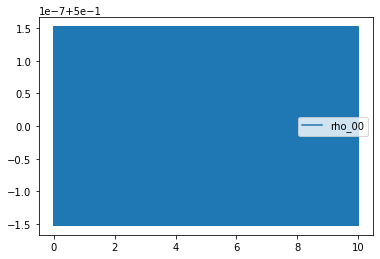

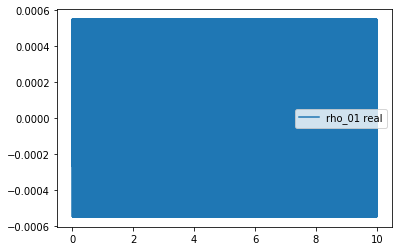

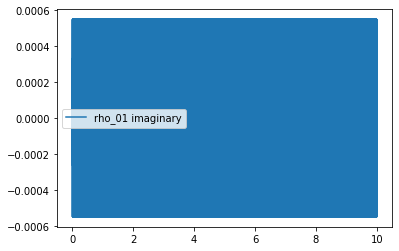

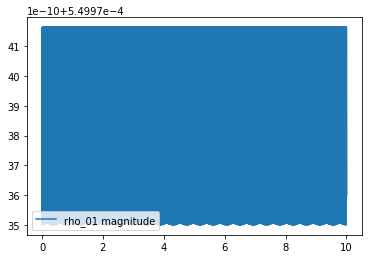

In [27]:
plt.figure()
plt.plot(t_elliot,rho_00.real,label='rho_00')
plt.legend()
plt.show()
plt.figure()
plt.plot(t_elliot,rho_01.real,label='rho_01 real')
plt.legend()
plt.show()
plt.figure()
plt.plot(t_elliot,rho_01.imag,label='rho_01 imaginary')
plt.legend()
plt.show()
plt.figure()
plt.plot(t_elliot,abs(rho_01),label='rho_01 magnitude')
plt.legend()
plt.show()

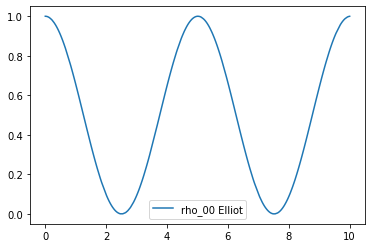

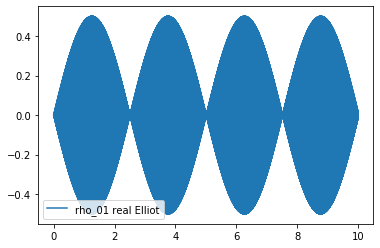

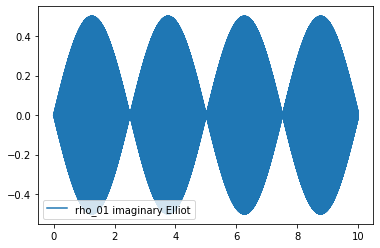

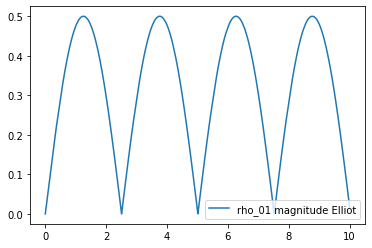

In [28]:
plt.figure()
plt.plot(t_elliot,rho_00_Elliot.real,label='rho_00 Elliot')
plt.legend()
plt.show()
plt.figure()
plt.plot(t_elliot,rho_01_Elliot.real,label='rho_01 real Elliot')
plt.legend()
plt.show()
plt.figure()
plt.plot(t_elliot,rho_01_Elliot.imag,label='rho_01 imaginary Elliot')
plt.legend()
plt.show()
plt.figure()
plt.plot(t_elliot,abs(rho_01_Elliot),label='rho_01 magnitude Elliot')
plt.legend()
plt.show()

/home/moormanc212/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


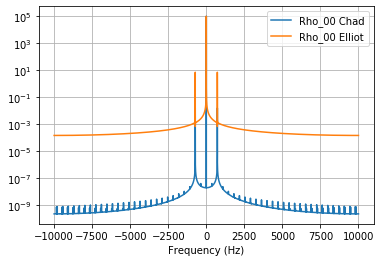

In [35]:
Rho_01 = abs(np.fft.fft(rho_01))
Rho_00 = abs(np.fft.fft(rho_00))
Rho_01_Elliot = np.fft.fft(rho_01_Elliot)
Rho_00_Elliot = np.fft.fft(rho_00_Elliot)
freq = np.fft.fftshift(np.fft.fftfreq(rho_01.size,d=dt))

plt.figure()
plt.semilogy(freq,np.fft.fftshift(Rho_00), label='Rho_00 Chad')
plt.semilogy(freq,np.fft.fftshift(abs(Rho_00_Elliot)), label='Rho_00 Elliot')
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.show()

/home/moormanc212/anaconda3/lib/python3.7/site-packages/IPython/core/pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


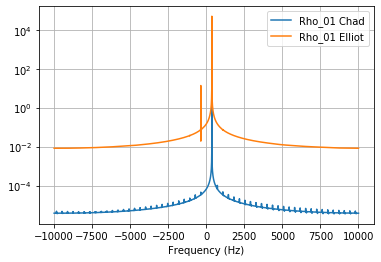

In [30]:
min_freq = 0
max_freq = freq.size

plt.figure()
plt.semilogy(freq[min_freq:max_freq],np.fft.fftshift(Rho_01)[min_freq:max_freq],label='Rho_01 Chad')
plt.semilogy(freq[min_freq:max_freq],np.fft.fftshift(abs(Rho_01_Elliot))[min_freq:max_freq],label='Rho_01 Elliot')
plt.legend()
plt.grid()
plt.xlabel('Frequency (Hz)')
plt.show()

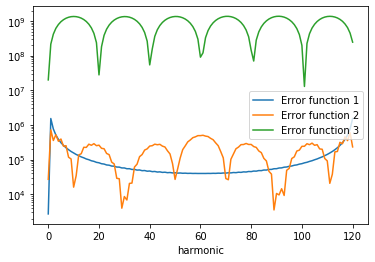

In [31]:
plt.figure()
f1 = get_f(coefficient_guesses)[:2*max_harmonic+1]
f2 = get_f(coefficient_guesses)[2*max_harmonic+1:2*(2*max_harmonic+1)]
f3 = get_f(coefficient_guesses)[2*(2*max_harmonic+1):]
plt.semilogy(abs(f1),label='Error function 1')
plt.semilogy(abs(f2),label='Error function 2')
plt.semilogy(abs(f3),label='Error function 3')
plt.legend()
plt.xlabel('harmonic')
plt.show()